# Assignment (Week1, Week2)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import numpy as np
import re
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
!pip install nltk

import warnings
warnings.filterwarnings("ignore")

In [26]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Major Project Online Hate Speech - English/dataset/hinglish.csv")

In [27]:
df.head()

,comment,isHate
0,Triple Talaq par Burbak Kuchh nahi bolega,0
1,Batao ye uss site pr se akki sir ke verdict ni...,1
2,Hindu baheno par julam bardas nahi hoga @Tripl...,0
3,Naa bhai.. aisa nhi hai.. mere handle karne se...,0
4,#RememberingRajiv aaj agar musalman auraten tr...,0


In [28]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
comment    0
isHate     0
dtype: int64


In [29]:
# Check the distribution of classes
class_distribution = df['isHate'].value_counts()
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
isHate
0    4746
1     504
Name: count, dtype: int64


In [30]:
# Check data types of columns
data_types = df.dtypes
print("Data Types:")
print(data_types)

Data Types:
comment    object
isHate      int64
dtype: object


In [31]:
# Function to remove non-English characters and punctuation
def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-English characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [32]:
# Function to fix contractions
def fix_contractions(text):
    contraction_dict = {"n't": "not", "'s": "is", "'re": "are", "'m": "am", "'ll": "will", "'ve": "have", "'d": "would"}
    for key, value in contraction_dict.items():
        text = text.replace(key, value)
    return text

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# Tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [35]:
# Function for basic spell correction
def candidates(word):
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

In [36]:
def known(words):
    return set(w for w in words if w in vocab)

In [37]:
def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [38]:
# Apply data cleaning and preprocessing
df['comment'] = df['comment'].apply(clean_text)
df['comment'] = df['comment'].apply(fix_contractions)

df['tokenized_comment'] = df['comment'].apply(lambda x: [lemmatizer.lemmatize(word) for word in word_tokenize(x.lower()) if word not in stop_words])

In [39]:
# Convert texts to sequences
max_words = 10000  # Maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_comment'])
sequences = tokenizer.texts_to_sequences(df['tokenized_comment'])

In [40]:
# Pad sequences
max_len = 100  # Maximum sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

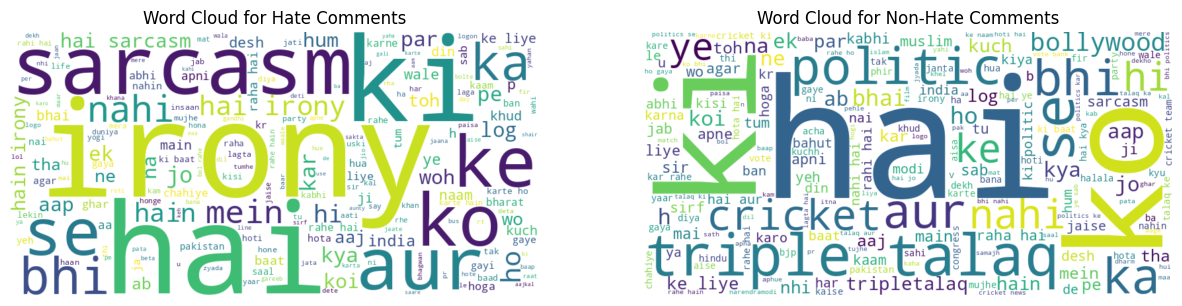

In [41]:
# Generate word cloud for hate and non-hate comments separately
hate_comments = ' '.join(df[df['isHate'] == 1]['tokenized_comment'].apply(lambda x: ' '.join(x)))
non_hate_comments = ' '.join(df[df['isHate'] == 0]['tokenized_comment'].apply(lambda x: ' '.join(x)))

wordcloud_hate = WordCloud(width=800, height=400, background_color='white').generate(hate_comments)
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_comments)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.title('Word Cloud for Hate Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.title('Word Cloud for Non-Hate Comments')
plt.axis('off')

plt.show()

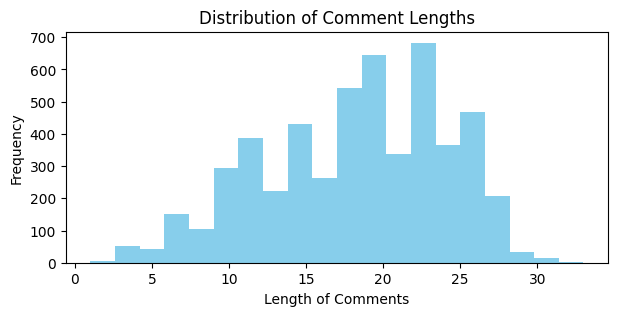

In [42]:
# Distribution of comment lengths
comment_lengths = df['tokenized_comment'].apply(len)
plt.figure(figsize=(7, 3))
plt.hist(comment_lengths, bins=20, color='skyblue')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comments')
plt.ylabel('Frequency')
plt.show()

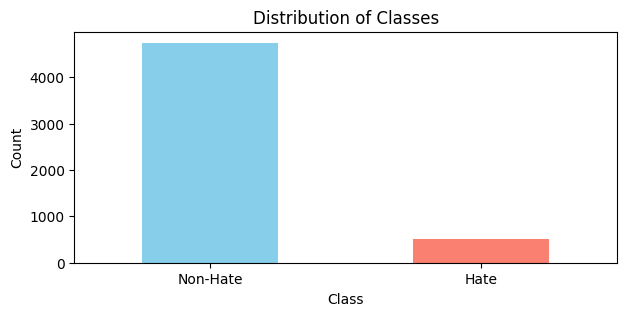

In [43]:
# Distribution of classes
plt.figure(figsize=(7, 3))
df['isHate'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Hate', 'Hate'], rotation=0)
plt.show()


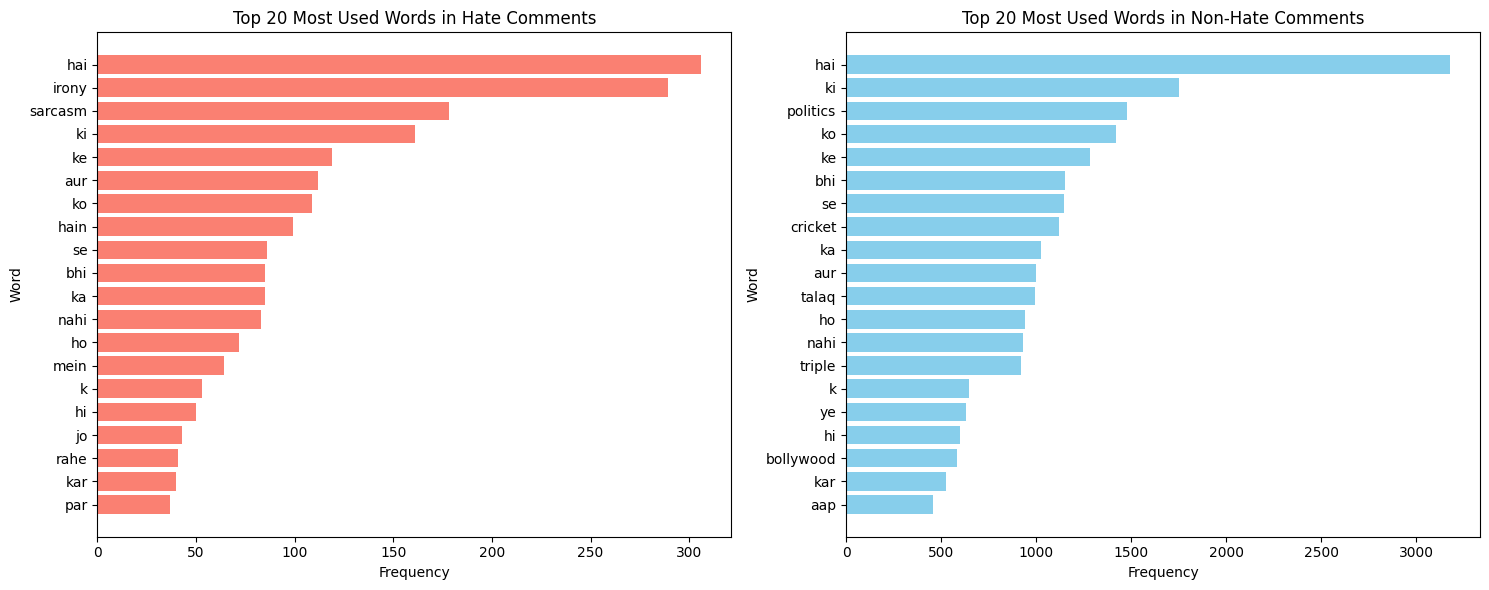

In [44]:
# Get the frequency of each word in hate and non-hate comments separately
hate_word_freq = {}
non_hate_word_freq = {}

for index, row in df.iterrows():
    comment = row['tokenized_comment']
    is_hate = row['isHate']
    for word in comment:
        if is_hate == 1:
            if word in hate_word_freq:
                hate_word_freq[word] += 1
            else:
                hate_word_freq[word] = 1
        else:
            if word in non_hate_word_freq:
                non_hate_word_freq[word] += 1
            else:
                non_hate_word_freq[word] = 1

# Sort the words by frequency for hate and non-hate comments
sorted_hate_word_freq = sorted(hate_word_freq.items(), key=lambda x: x[1], reverse=True)
sorted_non_hate_word_freq = sorted(non_hate_word_freq.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most used words for hate and non-hate comments
top_hate_words = sorted_hate_word_freq[:20]
top_non_hate_words = sorted_non_hate_word_freq[:20]

# Plot the top 20 most used words for hate comments
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(top_hate_words)), [word[1] for word in top_hate_words], align='center', color='salmon')
plt.yticks(range(len(top_hate_words)), [word[0] for word in top_hate_words])
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word at the top
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Used Words in Hate Comments')

# Plot the top 20 most used words for non-hate comments
plt.subplot(1, 2, 2)
plt.barh(range(len(top_non_hate_words)), [word[1] for word in top_non_hate_words], align='center', color='skyblue')
plt.yticks(range(len(top_non_hate_words)), [word[0] for word in top_non_hate_words])
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word at the top
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Used Words in Non-Hate Comments')

plt.tight_layout()
plt.show()

In [22]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['isHate'], test_size=0.2, random_state=42)

In [23]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg_params = {'C': [0.01, 0.1, 1, 10]}
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5)
log_reg_grid.fit(X_train, y_train)
log_reg_best = log_reg_grid.best_estimator_
log_reg_pred = log_reg_best.predict(X_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)

In [ ]:
# SVM
svm = SVC()
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(svm, svm_params, cv=5)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

In [ ]:
# LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 64, input_length=max_len))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

lstm_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
lstm_acc = accuracy_score(y_test, lstm_pred)

Epoch 1/10
20/20 [==============================] - 16s 483ms/step - loss: 0.6886 - accuracy: 0.5634 - val_loss: 0.6718 - val_accuracy: 0.6125
Epoch 2/10
20/20 [==============================] - 10s 492ms/step - loss: 0.6311 - accuracy: 0.7371 - val_loss: 0.5860 - val_accuracy: 0.7625
Epoch 3/10
20/20 [==============================] - 8s 407ms/step - loss: 0.3744 - accuracy: 0.8701 - val_loss: 0.4248 - val_accuracy: 0.8625
Epoch 4/10
20/20 [==============================] - 6s 314ms/step - loss: 0.1905 - accuracy: 0.9515 - val_loss: 0.3645 - val_accuracy: 0.8625
Epoch 5/10
20/20 [==============================] - 9s 425ms/step - loss: 0.2610 - accuracy: 0.9562 - val_loss: 3.3539 - val_accuracy: 0.5500
Epoch 6/10
20/20 [==============================] - 6s 326ms/step - loss: 1.4468 - accuracy: 0.6667 - val_loss: 0.5886 - val_accuracy: 0.8438
Epoch 7/10
20/20 [==============================] - 8s 374ms/step - loss: 0.1591 - accuracy: 0.9452 - val_loss: 0.5221 - val_accuracy: 0.8500
Epoc

In [ ]:
# CNN
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 64, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

cnn_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
cnn_acc = accuracy_score(y_test, cnn_pred)

Epoch 1/10
20/20 [==============================] - 5s 110ms/step - loss: 0.6868 - accuracy: 0.5681 - val_loss: 0.6742 - val_accuracy: 0.7312
Epoch 2/10
20/20 [==============================] - 2s 95ms/step - loss: 0.6304 - accuracy: 0.8529 - val_loss: 0.6243 - val_accuracy: 0.7437
Epoch 3/10
20/20 [==============================] - 1s 36ms/step - loss: 0.5085 - accuracy: 0.9108 - val_loss: 0.4910 - val_accuracy: 0.8625
Epoch 4/10
20/20 [==============================] - 1s 34ms/step - loss: 0.3083 - accuracy: 0.9280 - val_loss: 0.3408 - val_accuracy: 0.9125
Epoch 5/10
20/20 [==============================] - 1s 46ms/step - loss: 0.1475 - accuracy: 0.9577 - val_loss: 0.2877 - val_accuracy: 0.9000
Epoch 6/10
20/20 [==============================] - 1s 59ms/step - loss: 0.0614 - accuracy: 0.9906 - val_loss: 0.2825 - val_accuracy: 0.9000
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.2817 - val_accuracy: 0.9062
Epoch 8/10
2

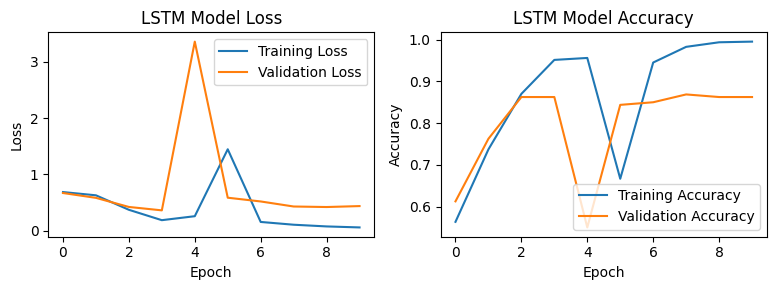

In [ ]:
# Plot loss vs accuracy for LSTM
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

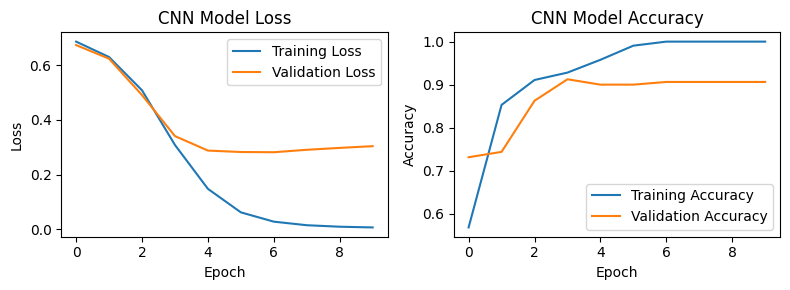

In [ ]:
# Plot loss vs accuracy for CNN
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression
log_reg_report = classification_report(y_test, log_reg_pred)
print("Logistic Regression:")
print(log_reg_report)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.56      0.63       106
           1       0.61      0.78      0.68        94

    accuracy                           0.66       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.68      0.66      0.66       200



In [ ]:
# SVM
svm_report = classification_report(y_test, svm_pred)
print("\nSVM:")
print(svm_report)


SVM:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       106
           1       0.82      0.91      0.86        94

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



In [ ]:
# LSTM
lstm_report = classification_report(y_test, lstm_pred)
print("\nLSTM:")
print(lstm_report)


LSTM:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       106
           1       0.85      0.82      0.83        94

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



In [ ]:
# CNN
cnn_report = classification_report(y_test, cnn_pred)
print("\nCNN:")
print(cnn_report)


CNN:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       106
           1       0.90      0.79      0.84        94

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



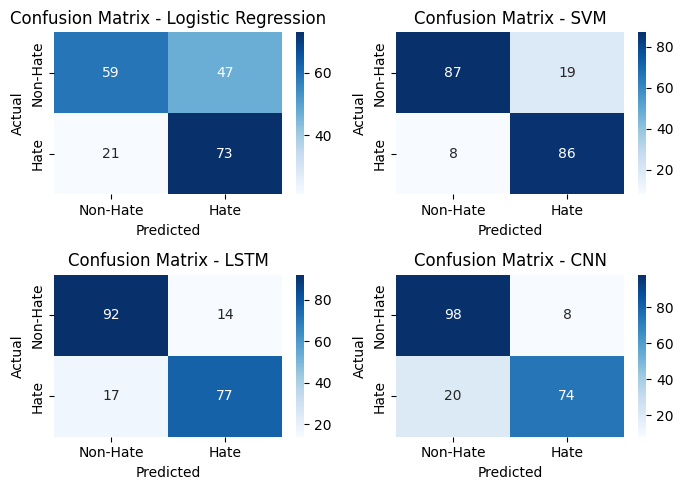

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model_name}')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

# Plot confusion matrices for each model
plot_confusion_matrix('Logistic Regression', y_test, log_reg_pred, ax=axes[0, 0])
plot_confusion_matrix('SVM', y_test, svm_pred, ax=axes[0, 1])
plot_confusion_matrix('LSTM', y_test, lstm_pred, ax=axes[1, 0])
plot_confusion_matrix('CNN', y_test, cnn_pred, ax=axes[1, 1])

plt.tight_layout()
plt.show()

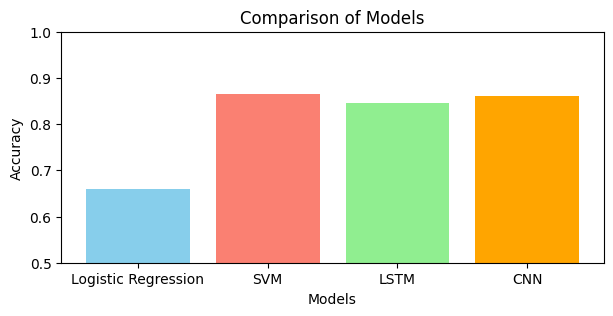

In [ ]:
models = ['Logistic Regression', 'SVM', 'LSTM', 'CNN']
accuracies = [log_reg_acc, svm_acc, lstm_acc, cnn_acc]

plt.figure(figsize=(7, 3))
plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Models')
plt.ylim(0.5, 1)
plt.show()